In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import random
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

# Functions for extracting features

In [3]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute binned color features  
#def bin_spatial(img, size=(32, 32)):
#    # Use cv2.resize().ravel() to create the feature vector
#    features = cv2.resize(img, size).ravel() 
#    # Return the feature vector
#    return features
                 
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Function for extracting HOG features

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Function for extracting combined HOG features

In [10]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

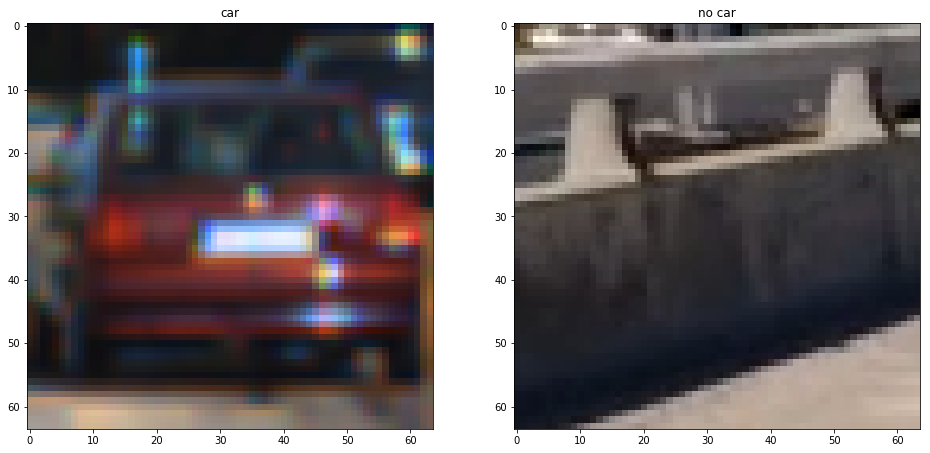

In [11]:
# Plot the result
f, ax_list = plt.subplots(1, 2, figsize=(16, 8))
images = [cars[1], notcars[1]];
ax_list = ax_list.flatten()
for i in range(2):    
    ax_list[i].imshow(mpimg.imread(images[i]))
    ax_list[i].set_title('%s' % ("car" if i % 2 == 0 else "no car") )
plt.show()

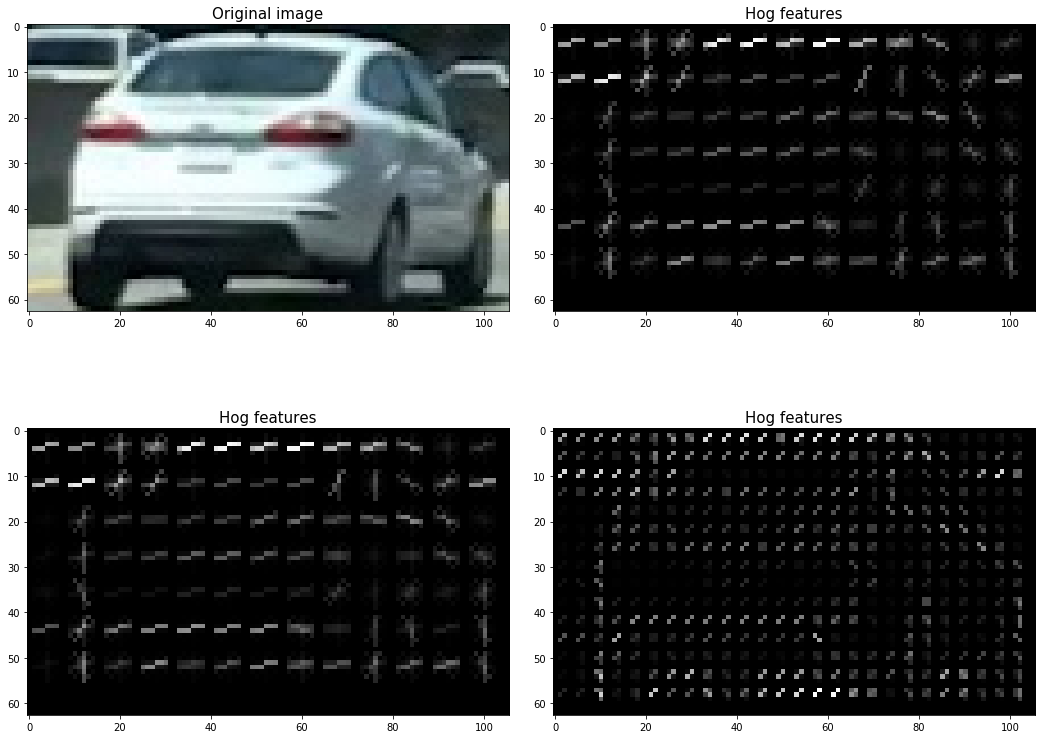

In [7]:
image = mpimg.imread('training_data/cutouts/cutout1.jpg')

color_space    = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9  # HOG orientations
pix_per_cell   = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel    = 0 # Can be 0, 1, 2, or "ALL"

_, hog_image1 = get_hog_features(image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog_image2 = get_hog_features(image[:,:,hog_channel], 7, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog_image3 = get_hog_features(image[:,:,hog_channel], orient, pix_per_cell/2, cell_per_block*2, vis=True, feature_vec=True)

# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
#print(ax)
f.tight_layout()
ax1.imshow(image);                  ax1.set_title('Original image', fontsize=15)
ax2.imshow(hog_image1, cmap='gray'); ax2.set_title('Hog features', fontsize=15)
ax3.imshow(hog_image2, cmap='gray'); ax3.set_title('Hog features', fontsize=15)
ax4.imshow(hog_image3, cmap='gray'); ax4.set_title('Hog features', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

In [8]:
images = glob.glob('training_data/cutouts/cutout*.jpg')
features = extract_features([images[0]], color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)
print(images)
print(features)
print((features[0]).shape)

['training_data/cutouts/cutout1.jpg', 'training_data/cutouts/cutout2.jpg', 'training_data/cutouts/cutout3.jpg', 'training_data/cutouts/cutout4.jpg', 'training_data/cutouts/cutout5.jpg', 'training_data/cutouts/cutout6.jpg']
[array([  1.22000000e+02,   1.42000000e+02,   1.48000000e+02, ...,
         1.39623545e-02,   1.64011323e-02,   9.09136948e-02])]
(5760,)


# Loading of training data and fitting of SVM

In [12]:
# Divide up into cars and notcars
cars = []
notcars = []

for subdir in glob.glob('training_data/non-vehicles/*'): notcars.extend(glob.glob(subdir + '/*.png'));
for subdir in glob.glob('training_data/vehicles/*'): cars.extend(glob.glob(subdir + '/*.png'))

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = len(cars) # +8000

cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

# Shuffle
random.shuffle(cars)
random.shuffle(notcars)

In [13]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)  
print("sample_size", sample_size)
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print(len(X_scaler.mean_)) #8460

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

# Check the prediction time for a single sample
t = time.time()
n_predict = 15
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

sample_size 8792
(17584, 8460)
8460
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
18.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9929
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.]
For these 15 labels:  [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  1.  0.]
0.00429 Seconds to predict 15 labels with SVC


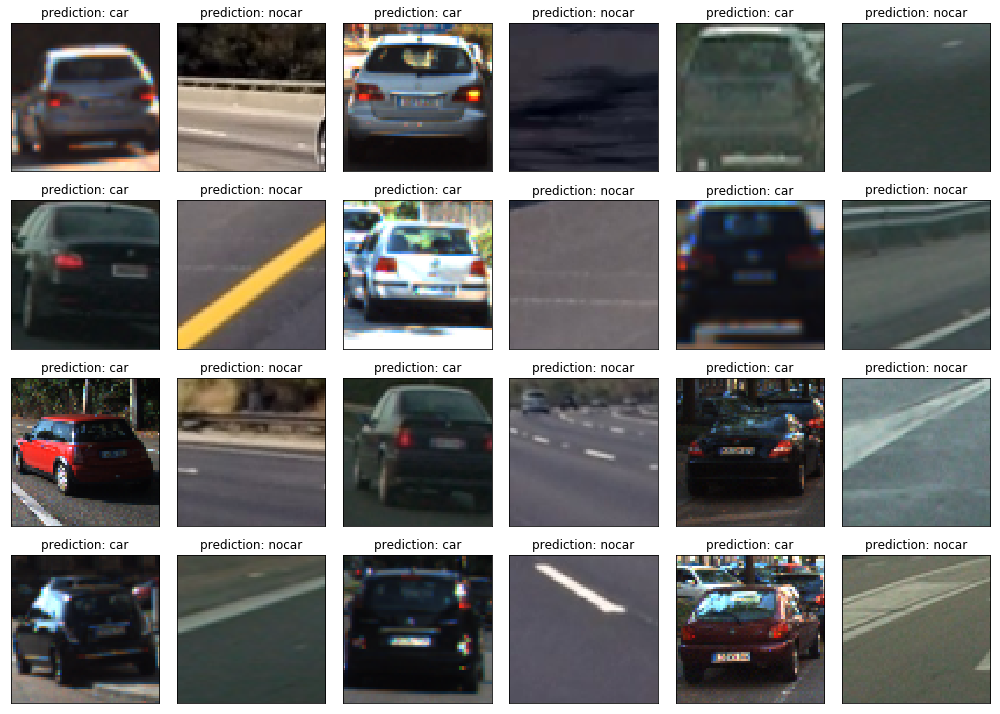

In [14]:
# Check the prediction time for a single sample and plot the result
n_predict = 6*4
f, ax_list = plt.subplots(4, int(n_predict/4), figsize=(14, 10))
ax_list = ax_list.flatten()
for i in range(n_predict):
    if i % 2 == 0:
        image = cars[i]
        txt   = 'car'
    else:
        image = notcars[i]        
        txt   = 'nocar'
        
    features = extract_features([image], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    scaled_X = X_scaler.transform(np.array(features).astype(np.float64))
    y_test = svc.predict(scaled_X)
    
    ax_list[i].imshow(mpimg.imread(image))
    ax_list[i].set_title('prediction: %s' % ("car" if y_test[0] else "nocar") )
    ax_list[i].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',
        labelleft='off',
        labelbottom='off') # labels along the bottom edge are off    
    ax_list[i].tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',
        labelleft='off',
        labelbottom='off') # labels along the bottom edge are off        
f.tight_layout()
plt.show()

In [15]:
data = {
    "svc": svc,
    "scaler": X_scaler,
    "orient": orient,
    "pix_per_cell": pix_per_cell,
    "cell_per_block": cell_per_block,
    "spatial_size": spatial_size,
    "hist_bins": hist_bins}
pickle.dump( data, open("svc_pickle.p", "wb" ) )
#print(data)

# Sliding window search

In [143]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

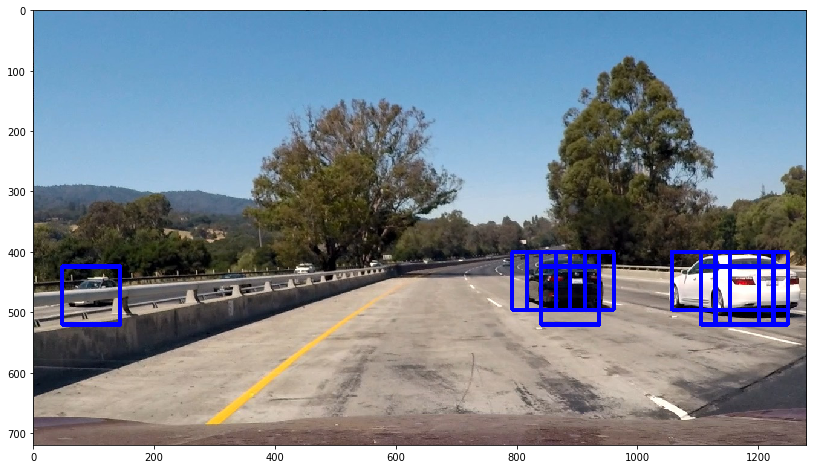

In [16]:
#img = mpimg.imread('test_image.jpg')
img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('training_data/cutouts/bbox-example-image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, drawBoxes=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    box_list = [];
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            stack = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1);
            test_features = X_scaler.transform(stack)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)));                
                if drawBoxes:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, box_list
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.figure(figsize=(16,8))
plt.imshow(out_img)

# Detecting false positives / heat map

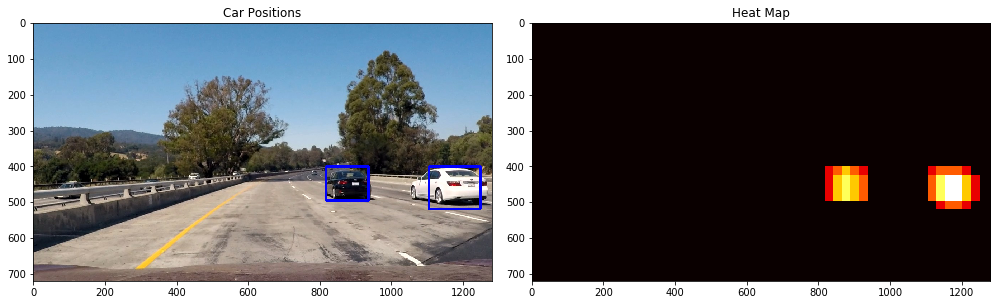

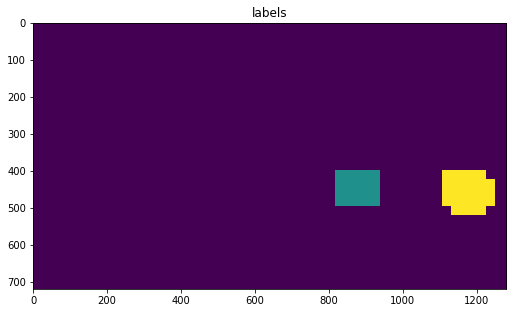

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" )) # <<<<<<<<<<<

# Read in image similar to one shown above 
#image = mpimg.imread('test_images/test4.jpg')
#image = mpimg.imread('training_data/cutouts/bbox-example-image.jpg')
image = img;
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


fig = plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(labels[0])
plt.title('labels')
#plt.subplot(122)
#plt.imshow(heatmap, cmap='hot')
#p#lt.title('Heat Map')
fig.tight_layout()


# Video

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import time

In [36]:
class Vehicle():
    def __init__(self, id):
        # was the vehicle detected in the last iteration?
        self.detected = False;
        # Number of times this vehicle has been detected?
        self.n_detection = 0;
        self.xpixels = None
        self.ypixels = None
        self.recent  = None
        self.id      = id;
        
    def reset(self):
        self.detected = False;
        
    def end_of_detection(self):
        if not self.detected:
            self.n_detection = 0
        
    def add_frame(self, x, y, w, h):
        self.bbox = ((x, y), (w, h));
        self.detected = True;
        self.n_detection += 1
        if self.recent is None:
            self.recent = np.array([[x,y,w,h]], dtype=int)
        else:
            self.recent = np.vstack( (self.recent, [x,y,w,h] ) ) 

    def get_bbox_smooth(self):
        # smooth over last five frames if possible
        if self.detected and self.n_detection > 0 and self.n_detection < 5:
            m =  self.recent[-self.n_detection,:];
            box = ((int(m[0]), int(m[1])), (int(m[2]), int(m[3])))
            return box
        if self.detected and self.n_detection >= 5:
            m =  np.mean(self.recent[-5:,:],axis=0).astype(np.int)
            box = ((int(m[0]), int(m[1])), (int(m[2]), int(m[3])))
            return box
        else:
            return None
        
    def color(self):
        if self.id == 0: return (255,0,0)
        if self.id == 1: return (255,0,255)
        if self.id == 2: return (0,255,255)
        if self.id == 3: return (255,100,0)
        if self.id == 4: return (255,0,100)
        if self.id == 5: return (100,100,0)    
        else: return (255,255,255)

In [37]:
def detect_cars(labels, vlist):
    for i in range(len(vlist)): vlist[i].reset();
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        vlist[car_number].add_frame(np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy))
    for i in range(len(vlist)): vlist[i].end_of_detection();        

In [38]:
def draw_cars(img, vlist):
    for i in range(len(vlist)): 
        bbox = vlist[i].get_bbox_smooth();
        if not bbox is None:
            cv2.rectangle(img, bbox[0], bbox[1], vlist[i].color(), 6)       
    return img

In [39]:
vehicle_list = [];
for i in range(10): vehicle_list.append(Vehicle(i));
heat_map_before = [];

In [47]:
def process_image(image, movieMode = True):
    # The output you return should be a color image (3 channel) for processing video below
    _, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, drawBoxes=False)

    # Create empty heat list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Average heat map over last 3 frames
    heat_map_before.append(heat)
    if len(heat_map_before) > 3 and movieMode:
        heat_avg = np.mean(np.array(heat_map_before[-3:]),axis=0);
    else:
        heat_avg = heat;

    # Apply threshold to help remove false positives
    heat_avg = apply_threshold(heat_avg, 1.2) ## changed (vorher 1.5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_avg, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    detect_cars(labels, vehicle_list);
    draw_img = draw_cars(np.copy(image), vehicle_list)    
    
    return draw_img

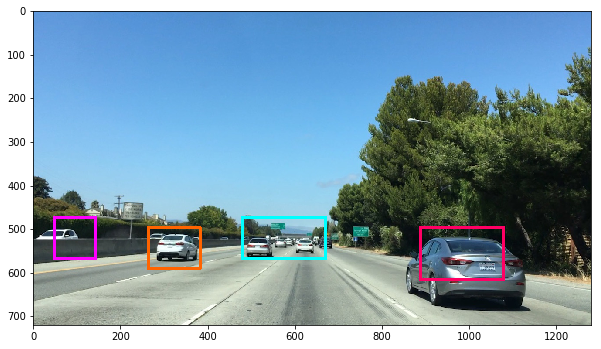

In [48]:
heat_map_before = []
vehicle_list = [];
for i in range(10): vehicle_list.append(Vehicle(i));

image = mpimg.imread('training_data/cutouts/bbox-example-image.jpg')
result = process_image(image, movieMode=False)
plt.figure(figsize=(20/2,14/2))
plt.imshow(result)
plt.show();

In [49]:
heat_map_before = []
vehicle_list = [];
for i in range(10): vehicle_list.append(Vehicle(i));

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(26,32)
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output3.mp4
[MoviePy] Writing video project_video_output3.mp4


100%|█████████▉| 1260/1261 [17:35<00:00,  1.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output3.mp4 

CPU times: user 14min 19s, sys: 56.1 s, total: 15min 15s
Wall time: 17min 36s


In [50]:
filename = video_output + ( "?t=" + str(time.time()) ); # disable firefox video caching by adding random number
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(filename))

# OLD

In [3]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [ ]:

### TODO: Tweak these parameters and see how the results change.
colorspace     = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9
pix_per_cell   = 8
cell_per_block = 2
hog_channel    = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [101]:
box_list = hot_windows;
print(box_list)
pickle.dump(box_list, open( "bbox_pickle.p", "wb" ))

[((912, 96), (1008, 192)), ((1008, 144), (1104, 240)), ((1056, 144), (1152, 240)), ((1152, 144), (1248, 240)), ((288, 480), (384, 576)), ((480, 480), (576, 576)), ((576, 480), (672, 576)), ((864, 528), (960, 624)), ((912, 528), (1008, 624)), ((960, 528), (1056, 624)), ((1008, 528), (1104, 624)), ((864, 576), (960, 672)), ((912, 576), (1008, 672)), ((960, 576), (1056, 672)), ((1008, 576), (1104, 672)), ((1056, 576), (1152, 672))]


In [98]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

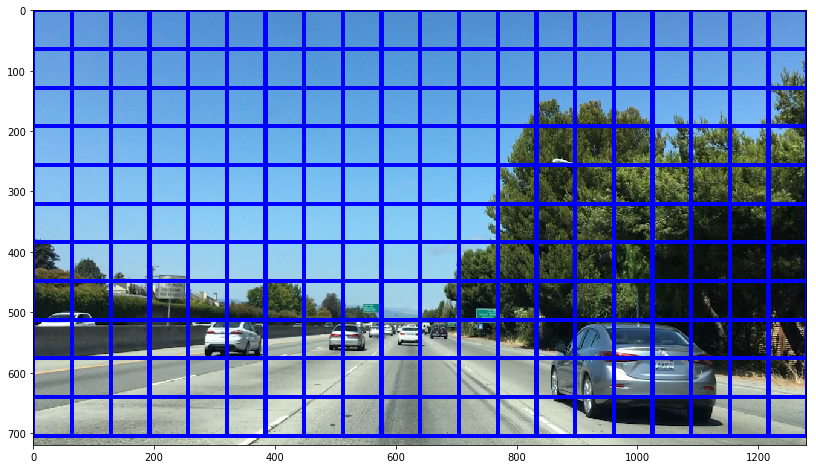

In [141]:
image = mpimg.imread('training_data/cutouts/bbox-example-image.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.figure(figsize=(16,8))
plt.imshow(window_img)

In [ ]:
   
#    match = np.zeros_like(labels[0]).astype(np.float)
#    match_all = match.copy();
#    for car_number in range(1, labels[1]+1):
#        print((labels[0] == car_number).nonzero().shape)
#        print(lables_previous[0].shape)        
 #       match = np.logical_and( (labels[0] == car_number) > 0, 
                                (lables_previous[0] == car_number) > 0 );
    
#        if np.sum(match.nonzero()) > 0:
#            match_all += car_number * labels[0];
    
# Iterate through all detected cars
   # for car_number in range(1, labels[1]+1):
   #     # Find pixels with each car_number label value
   #     nonzero = (labels[0] == car_number).nonzero()
   #     # Identify x and y values of those pixels
   #     nonzeroy = np.array(nonzero[0])
   #     nonzerox = np.array(nonzero[1])
   #     # Define a bounding box based on min/max x and y
   #     bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

#    return match_all


In [677]:
img1 = clip1.get_frame(0)
img2 = clip1.get_frame(0.1)
img3 = clip1.get_frame(0.8)
img4 = clip1.get_frame(0.9)
d1, l1 = process_image(img1)
d2, l2 = process_image(img2)
d3, l3 = process_image(img3)
d4, l4 = process_image(img4)

#labels_filtered = filter_cars(l3, l2)
    
plt.imshow(d1)
plt.show()
plt.imshow(d2)
plt.show()
plt.imshow(d3)
plt.show()
plt.imshow(d4)
plt.show()
plt.imshow(labels_filtered);
plt.show()

ValueError: too many values to unpack (expected 2)

In [168]:
image = mpimg.imread('training_data/cutouts/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.figure(figsize=(16,8))
plt.imshow(window_img)

ValueError: operands could not be broadcast together with shapes (1,4932) (8460,) (1,4932) 